# Script descartado de proyeccion para enderezar archivos

Comparando todos los métodos...


Probando: Proyección (Texto)
Método usado: proyeccion
Ángulo detectado: 0.600°

Probando: Hough Refinado
Método usado: hough_refinado
Ángulo detectado: 0.000°

Probando: Momentos (PCA)
Método usado: deskew_moments
Ángulo detectado: -3.950°

Probando: Combinado (Todos)
  Ángulos detectados: ['0.60°', '0.00°', '-3.95°']
  Pesos: [3.0, 2.0, 1.5]
Método usado: combinado
Ángulo detectado: -0.635°


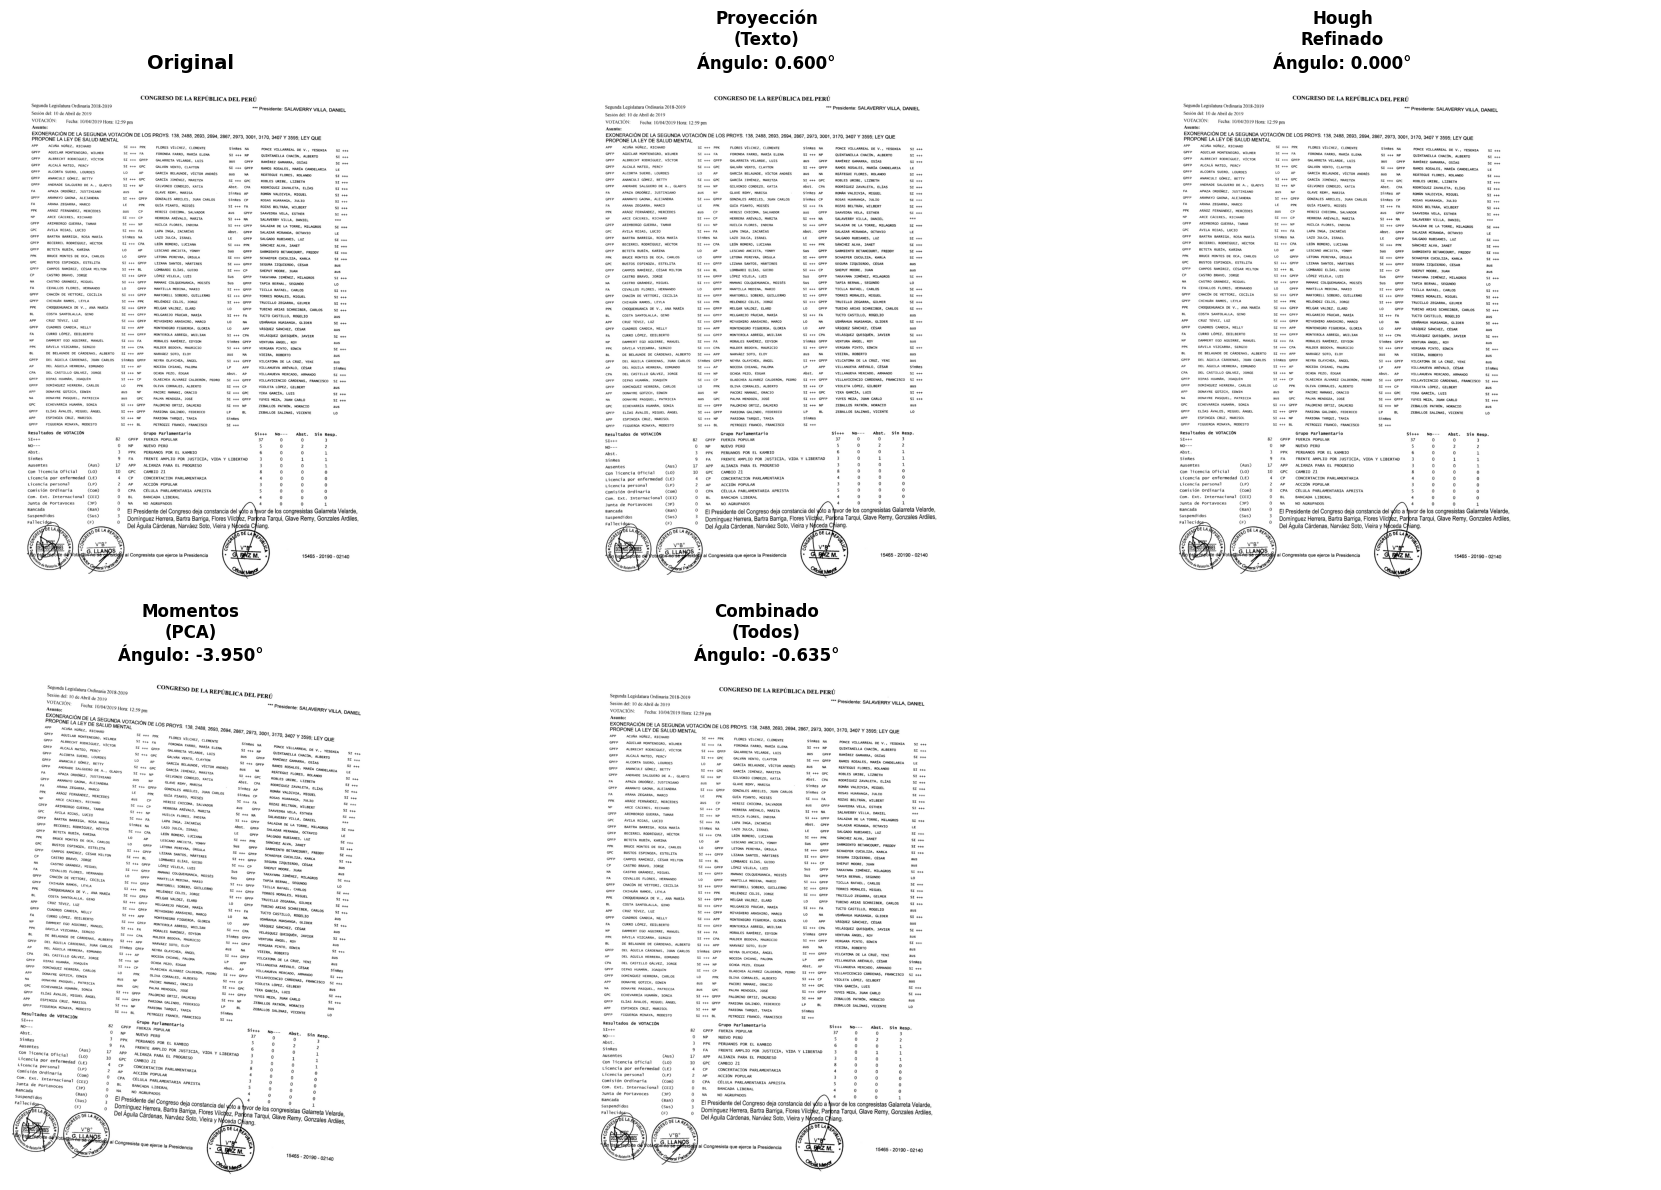

In [4]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage

def enderezar_documento_robusto(image_path, metodo='proyeccion'):
    """
    Métodos robustos para enderezar documentos con inclinaciones pequeñas (1-5°)
    
    Parámetros:
    - metodo: 'proyeccion', 'hough_refinado', 'deskew_moments', 'combinado'
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {image_path}")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if metodo == 'proyeccion':
        # MÉTODO 1: Proyección de píxeles (muy preciso para texto)
        angle = detectar_angulo_proyeccion(gray)
        
    elif metodo == 'hough_refinado':
        # MÉTODO 2: Hough refinado con búsqueda fina
        angle = detectar_angulo_hough_refinado(gray)
        
    elif metodo == 'deskew_moments':
        # MÉTODO 3: Momentos de imagen (robusto y rápido)
        angle = detectar_angulo_momentos(gray)
        
    elif metodo == 'combinado':
        # MÉTODO 4: Combinación de métodos (más robusto)
        angle = detectar_angulo_combinado(gray)
    
    else:
        raise ValueError("Método no válido")
    
    print(f"Método usado: {metodo}")
    print(f"Ángulo detectado: {angle:.3f}°")
    
    # Rotar imagen
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), 
                              flags=cv2.INTER_CUBIC,
                              borderMode=cv2.BORDER_REPLICATE)
    
    return rotated, angle


def detectar_angulo_proyeccion(gray):
    """
    MÉTODO 1: Proyección de varianza (muy preciso para documentos con texto)
    Busca el ángulo donde las líneas de texto están más alineadas
    """
    # Binarizar
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = 255 - binary  # Invertir (texto negro sobre blanco)
    
    # Buscar en rango pequeño con pasos finos
    angles = np.arange(-5, 5, 0.1)  # De -5° a +5° en pasos de 0.1°
    scores = []
    
    for angle in angles:
        # Rotar imagen
        rotated = ndimage.rotate(binary, angle, reshape=False, order=0)
        
        # Calcular proyección horizontal (suma de píxeles por fila)
        projection = np.sum(rotated, axis=1)
        
        # La varianza será máxima cuando las líneas estén alineadas
        score = np.var(projection)
        scores.append(score)
    
    # El ángulo con mayor varianza es el correcto
    best_idx = np.argmax(scores)
    best_angle = angles[best_idx]
    
    return best_angle


def detectar_angulo_hough_refinado(gray):
    """
    MÉTODO 2: Transformada de Hough con búsqueda refinada
    """
    # Preprocesamiento agresivo
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100, apertureSize=3)
    
    # Detectar líneas largas (más confiables)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 
                            threshold=100, 
                            minLineLength=200, 
                            maxLineGap=10)
    
    if lines is None:
        return 0
    
    # Calcular ángulos de líneas largas
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calcular ángulo respecto a la horizontal
        if x2 - x1 != 0:
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            
            # Normalizar ángulos casi horizontales (líneas de texto)
            if abs(angle) < 10:
                angles.append(angle)
            # Normalizar ángulos casi verticales (bordes de página)
            elif abs(angle - 90) < 10 or abs(angle + 90) < 10:
                vertical_angle = (angle - 90) if angle > 0 else (angle + 90)
                angles.append(vertical_angle)
    
    if not angles:
        return 0
    
    # Usar mediana para robustez contra outliers
    return np.median(angles)


def detectar_angulo_momentos(gray):
    """
    MÉTODO 3: Momentos de imagen (muy robusto)
    Basado en la distribución de píxeles en la imagen
    """
    # Binarizar
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Calcular momentos
    coords = np.column_stack(np.where(binary > 0))
    
    if len(coords) < 2:
        return 0
    
    # Calcular el ángulo principal usando PCA (componentes principales)
    coords = coords.astype(np.float32)
    mean = np.mean(coords, axis=0)
    coords_centered = coords - mean
    
    # Matriz de covarianza
    cov = np.cov(coords_centered.T)
    
    # Eigenvalores y eigenvectores
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    
    # El eigenvector con mayor eigenvalue indica la dirección principal
    idx = eigenvalues.argsort()[::-1]
    eigenvector = eigenvectors[:, idx[0]]
    
    # Calcular ángulo
    angle = np.degrees(np.arctan2(eigenvector[1], eigenvector[0]))
    
    # Ajustar ángulo para que sea respecto a la vertical
    if angle > 45:
        angle = angle - 90
    elif angle < -45:
        angle = angle + 90
    
    return angle


def detectar_angulo_combinado(gray):
    """
    MÉTODO 4: Combina múltiples métodos para mayor robustez
    """
    angulos = []
    pesos = []
    
    # Método 1: Proyección
    try:
        ang1 = detectar_angulo_proyeccion(gray)
        angulos.append(ang1)
        pesos.append(3.0)  # Mayor peso (más confiable para documentos de texto)
    except:
        pass
    
    # Método 2: Hough refinado
    try:
        ang2 = detectar_angulo_hough_refinado(gray)
        if abs(ang2) < 10:  # Solo si es razonable
            angulos.append(ang2)
            pesos.append(2.0)
    except:
        pass
    
    # Método 3: Momentos
    try:
        ang3 = detectar_angulo_momentos(gray)
        if abs(ang3) < 10:  # Solo si es razonable
            angulos.append(ang3)
            pesos.append(1.5)
    except:
        pass
    
    if not angulos:
        return 0
    
    # Promedio ponderado
    angulo_final = np.average(angulos, weights=pesos)
    
    print(f"  Ángulos detectados: {[f'{a:.2f}°' for a in angulos]}")
    print(f"  Pesos: {pesos}")
    
    return angulo_final


def visualizar_comparacion_metodos(image_path):
    """
    Compara todos los métodos lado a lado
    """
    img_original = cv2.imread(image_path)
    img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    
    metodos = ['proyeccion', 'hough_refinado', 'deskew_moments', 'combinado']
    nombres = ['Proyección\n(Texto)', 'Hough\nRefinado', 'Momentos\n(PCA)', 'Combinado\n(Todos)']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Original
    axes[0].imshow(img_original_rgb)
    axes[0].set_title('Original', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Cada método
    resultados = []
    for i, (metodo, nombre) in enumerate(zip(metodos, nombres)):
        print(f"\n{'='*50}")
        print(f"Probando: {nombre.replace(chr(10), ' ')}")
        print('='*50)
        
        img_rotada, angulo = enderezar_documento_robusto(image_path, metodo=metodo)
        img_rotada_rgb = cv2.cvtColor(img_rotada, cv2.COLOR_BGR2RGB)
        
        axes[i+1].imshow(img_rotada_rgb)
        axes[i+1].set_title(f'{nombre}\nÁngulo: {angulo:.3f}°', 
                           fontsize=12, fontweight='bold')
        axes[i+1].axis('off')
        
        resultados.append((metodo, angulo, img_rotada))
    
    # Ocultar último subplot vacío
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return resultados


def enderezar_y_guardar(image_path, output_path=None, metodo='combinado'):
    """
    Endereza y guarda usando el mejor método
    """
    img_rotada, angulo = enderezar_documento_robusto(image_path, metodo=metodo)
    
    if output_path is None:
        output_path = image_path.replace('.png', '_enderezada.png')
    
    cv2.imwrite(output_path, img_rotada)
    print(f"\n✓ Imagen guardada en: {output_path}")
    print(f"✓ Rotación aplicada: {angulo:.3f}°")
    
    return output_path, angulo


# ========================================
# USAR EL CÓDIGO
# ========================================

ruta_imagen = '../data/c_comprimidos/430_pp2016_2021_pa2018_2019_leg2_page_14.jpg'

# Opción 1: Comparar todos los métodos (RECOMENDADO)
print("Comparando todos los métodos...\n")
resultados = visualizar_comparacion_metodos(ruta_imagen)

# Opción 2: Usar solo el método combinado (el mejor)
# img_rotada, angulo = enderezar_documento_robusto(ruta_imagen, metodo='combinado')

# Opción 3: Guardar con el mejor método
# enderezar_y_guardar(ruta_imagen, metodo='combinado')

In [ ]:
ruta_imagen = '../data/c_comprimidos/430_pp2016_2021_pa2018_2019_leg2_page_14.jpg'
